In [1]:
# Install optuna if not already installed
!pip install optuna

import pandas as pd
import optuna
from sklearn.model_selection import GroupKFold, cross_val_score, train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")


# Step 1: Load dataset
df = pd.read_csv('water_potability_final.csv')

# Step 2: Separate features and target
X = df.drop('Potability', axis=1)
y = df['Potability']

# Artificial groups for GroupKFold
groups = np.arange(len(X)) % 5

# Step 3: Train-test split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42
)

# Step 4: Define Optuna objective function for AdaBoost
def objective(trial):
    # Base estimator (Decision Tree)
    base_estimator = DecisionTreeClassifier(
        max_depth=trial.suggest_int("max_depth", 1, 10),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
        random_state=42
    )

    # AdaBoost hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 400),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
        "estimator": base_estimator,
        "random_state": 42
    }

    model = AdaBoostClassifier(**params)
    gkf = GroupKFold(n_splits=5)
    scores = cross_val_score(
        model, X_train, y_train,
        cv=gkf.split(X_train, y_train, groups_train),
        scoring='accuracy'
    )
    return scores.mean()

# Step 5: Run Optuna optimization (max 30 trials or 30 minutes)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=1800, show_progress_bar=True)

# Step 6: Train AdaBoost with best parameters
best_params = study.best_params

# Extract base estimator params separately
base_tree = DecisionTreeClassifier(
    max_depth=best_params.pop("max_depth"),
    min_samples_split=best_params.pop("min_samples_split"),
    min_samples_leaf=best_params.pop("min_samples_leaf"),
    random_state=42
)

ada_best = AdaBoostClassifier(
    estimator=base_tree,
    **best_params,
    random_state=42
)
ada_best.fit(X_train, y_train)

# Step 7: Evaluate model
y_pred = ada_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 8: Display results
results = pd.DataFrame([{
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}])

print("\n Water Potability Model Performance (AdaBoost):\n", results)
print("\n Best Parameters Found by Optuna:\n", best_params)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.3 MB/s eta 0:00:00


[I 2025-11-16 07:22:28,354] A new study created in memory with name: no-name-02c004e6-de85-48ff-988b-07213505f33a


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-16 07:22:59,698] Trial 0 finished with value: 0.7598390309049703 and parameters: {'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 1, 'n_estimators': 222, 'learning_rate': 0.020443092960883622}. Best is trial 0 with value: 0.7598390309049703.
[I 2025-11-16 07:23:52,408] Trial 1 finished with value: 0.7704796176362075 and parameters: {'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2, 'n_estimators': 325, 'learning_rate': 0.022038398071057654}. Best is trial 1 with value: 0.7704796176362075.
[I 2025-11-16 07:24:06,062] Trial 2 finished with value: 0.7572904710596949 and parameters: {'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 9, 'n_estimators': 169, 'learning_rate': 0.41085542292297034}. Best is trial 1 with value: 0.7704796176362075.
[I 2025-11-16 07:24:15,140] Trial 3 finished with value: 0.7708805678339754 and parameters: {'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 1, 'n_estimators': 59, 'learning_rate': 0.02549062

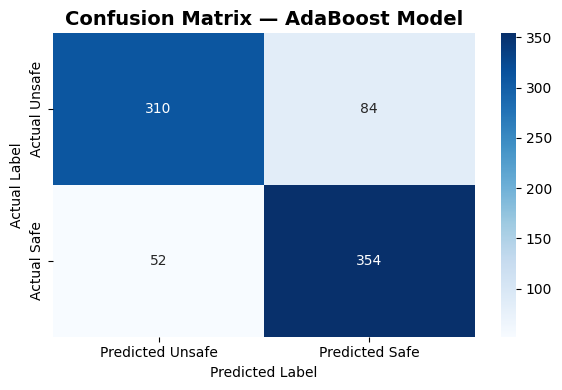

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Unsafe','Predicted Safe'],
            yticklabels=['Actual Unsafe','Actual Safe'])

plt.title('Confusion Matrix — AdaBoost Model', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()
